## 🔗 Open This Notebook in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DavidLangworthy/ds4s/blob/master/days/day03/starter/day03_starter.ipynb)

# 🌫️ Day 3 – Pollution and Public Health
### Linking air-quality exposure to economic development

Today we connect environmental conditions to human outcomes. We'll pair fine particulate (PM₂.₅) exposure with GDP per capita to explore how pollution burdens shift with income. Expect rapid feedback loops after every transformation so you can debug before plotting.

### Data card — World Bank World Development Indicators
- **Source:** [World Bank – World Development Indicators](https://data.worldbank.org/)
- **Indicators used:** PM2.5 air pollution, mean annual exposure (EN.ATM.PM25.MC.M3) and GDP per capita (NY.GDP.PCAP.CD)
- **Temporal coverage:** 1990–2023 (annual; earlier years sparse)
- **Geographic coverage:** Countries and regional aggregates
- **Units:** PM₂.₅ in micrograms per cubic meter; GDP per capita in current US dollars
- **Processing notes:** Files include metadata header rows and many blank cells; we need to reshape from wide to tidy format.
- **Caveats:** GDP is nominal (not adjusted for purchasing power) and pollution exposure estimates carry uncertainty, especially in low-income regions.

### Preview: today's target chart
You'll produce a scatter plot with a fitted trend line, annotated to emphasize the inequity of pollution exposure across income levels.

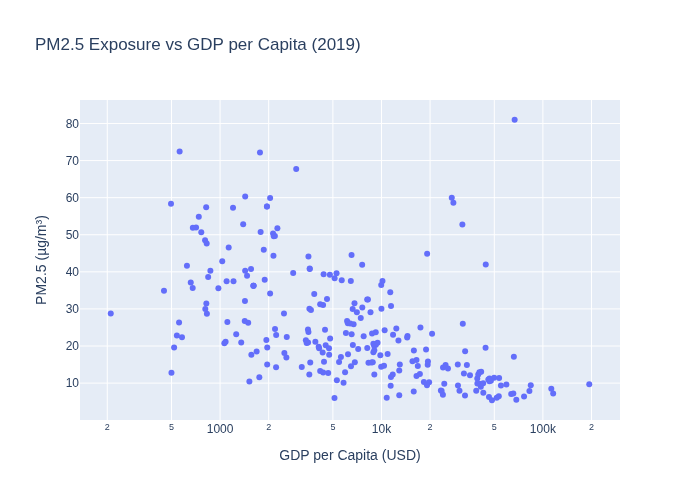

In [1]:
from pathlib import Path
from warnings import warn

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from IPython.display import Image, display

CANDIDATES = [Path.cwd(), *Path.cwd().parents]
for candidate in CANDIDATES:
    if (candidate / "data").exists():
        PROJECT_ROOT = candidate
        break
else:
    raise FileNotFoundError("Couldn't find the project root containing a data/ folder.")

DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_BASE = "https://raw.githubusercontent.com/DavidLangworthy/ds4s/master/data"
PLOTS_DIR = PROJECT_ROOT / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 110,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

COLORBLIND_FRIENDLY = ["#2E86AB", "#F18F01", "#A23B72", "#C73E1D", "#2EC4B6", "#33673B"]

if (PLOTS_DIR / "day03_solution_plot.png").exists():
    display(Image(filename=PLOTS_DIR / "day03_solution_plot.png", width=420))
else:
    print("Preview image not found; continue with the workflow.")


def load_data(csv_name: str, **read_kwargs) -> pd.DataFrame:
    path = DATA_DIR / csv_name
    if not path.exists():
        url = f"{RAW_DATA_BASE}/{csv_name}"
        print(f"Local file not found. Downloading {csv_name} from GitHub…")
        response = requests.get(url, timeout=30)
        try:
            response.raise_for_status()
        except requests.HTTPError as exc:
            raise FileNotFoundError(
                f"Could not retrieve {csv_name} from {url} (status {response.status_code})."
            ) from exc
        path.parent.mkdir(parents=True, exist_ok=True)
        path.write_bytes(response.content)
    df = pd.read_csv(path, **read_kwargs)
    print(f"Loaded {csv_name} → {df.shape[0]:,} rows × {df.shape[1]} columns.")
    return df

def validate_columns(df: pd.DataFrame, required: list[str]) -> None:
    missing = [col for col in required if col not in df.columns]
    if missing:
        warn(f"Missing columns: {missing}")
    else:
        print("✅ Columns look good:", required)


def expect_rows_between(df: pd.DataFrame, lower: int, upper: int) -> None:
    rows = len(df)
    if rows < lower or rows > upper:
        warn(f"Row count {rows:,} outside the expected range ({lower:,}–{upper:,}).")
    else:
        print(f"✅ Row count within expected range ({rows:,}).")


def quick_diagnostics(df: pd.DataFrame, name: str = "DataFrame") -> None:
    print(f"--- Quick check for {name} ---")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("Missing values:", df.isna().sum())
    display(df.head())


def check_story_fields(**fields) -> None:
    empty = [key for key, value in fields.items() if not str(value).strip()]
    if empty:
        warn(f"These storytelling fields still need text: {', '.join(empty)}")
    else:
        print("✅ Story scaffolding complete. Ready to plot!")


def baseline_style():
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams["axes.facecolor"] = "#F8FAFC"


def save_last_fig(filename: str) -> None:
    path = PLOTS_DIR / filename
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Figure saved to {path.relative_to(PROJECT_ROOT)}")


## Step 1. Load and inspect the PM₂.₅ dataset
World Bank CSVs include metadata rows; we skip them and reshape later.

In [2]:
pm25_wide = load_data("pm25_exposure.csv", encoding="utf-8-sig")
pm25_wide = pm25_wide.drop(columns=[col for col in pm25_wide.columns if col.startswith("Unnamed")])
quick_diagnostics(pm25_wide, name="PM2.5 wide format")


Loaded pm25_exposure.csv → 266 rows × 69 columns.
--- Quick check for PM2.5 wide format ---
Shape: (266, 68)
Columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Missing values: Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              266
                 ... 
2019               18
2020               18
2021              266
2022              266
2023              266
Length: 68, dtype: int64


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,"PM2.5 air pollution, mean annual exposure (mic...",EN.ATM.PM25.MC.M3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"PM2.5 air pollution, mean annual exposure (mic...",EN.ATM.PM25.MC.M3,NaN,NaN,NaN,NaN,NaN,NaN,...,27.779344,29.515468,28.877274,27.311377,27.404295,26.248200,26.755686,NaN,NaN,NaN
2,Afghanistan,AFG,"PM2.5 air pollution, mean annual exposure (mic...",EN.ATM.PM25.MC.M3,NaN,NaN,NaN,NaN,NaN,NaN,...,77.143728,73.490818,72.765910,65.862347,67.227177,58.330872,46.087094,NaN,NaN,NaN
3,Africa Western and Central,AFW,"PM2.5 air pollution, mean annual exposure (mic...",EN.ATM.PM25.MC.M3,NaN,NaN,NaN,NaN,NaN,NaN,...,47.135125,71.295051,62.894132,60.344618,56.099951,50.771962,54.891820,NaN,NaN,NaN
4,Angola,AGO,"PM2.5 air pollution, mean annual exposure (mic...",EN.ATM.PM25.MC.M3,NaN,NaN,NaN,NaN,NaN,NaN,...,23.945584,25.002150,25.180701,23.959151,24.265015,24.598811,25.145238,NaN,NaN,NaN


✅ **Checkpoint:** You should see columns `Country Name`, `Country Code`, indicator metadata, followed by year columns (1960…2023).

## Step 2. Load GDP per capita data
We'll follow the same pattern so both indicators share the same shape.

In [3]:
gdp_wide = load_data("gdp_per_country.csv", encoding="utf-8-sig")
gdp_wide = gdp_wide.drop(columns=[col for col in gdp_wide.columns if col.startswith("Unnamed")])
quick_diagnostics(gdp_wide, name="GDP wide format")


Loaded gdp_per_country.csv → 266 rows × 69 columns.
--- Quick check for GDP wide format ---
Shape: (266, 68)
Columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Missing values: Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              115
                 ... 
2019                7
2020                8
2021                8
2022               11
2023               23
Length: 68, dtype: int64


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,26129.839062,27458.225331,27441.529662,28440.051964,30082.127645,31096.205074,22855.932320,27200.061079,30559.533535,33984.790620
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,186.132432,186.947182,197.408105,225.447007,209.005786,226.883067,...,1656.107642,1479.564123,1329.777824,1520.171298,1538.924188,1493.780445,1344.080962,1522.590088,1628.024526,1659.515290
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,625.054942,565.569730,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,415.707417
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,121.938353,127.452629,133.825452,139.006714,148.547736,155.563837,...,2204.995700,1845.767804,1616.843198,1560.162999,1703.896392,1783.654365,1664.249176,1747.840549,1777.235012,1568.724310
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5005.999741,3213.902611,1807.952941,2437.259712,2538.591391,2189.855714,1449.922867,1925.874661,2929.694455,2308.159767


## Step 3. Tidy the datasets
Convert from wide to long format, keep country-level observations, and drop missing values.

In [4]:
def tidy_indicator(df: pd.DataFrame, value_name: str) -> pd.DataFrame:
    id_vars = ["Country Name", "Country Code"]
    value_vars = [col for col in df.columns if col.isdigit()]
    tidy = (
        df[id_vars + value_vars]
        .melt(id_vars=id_vars, value_vars=value_vars, var_name="Year", value_name=value_name)
        .dropna(subset=[value_name])
    )
    tidy["Year"] = tidy["Year"].astype(int)
    tidy[value_name] = tidy[value_name].astype(float)
    return tidy

pm25_long = tidy_indicator(pm25_wide, "pm25")
gdp_long = tidy_indicator(gdp_wide, "gdp_per_capita")

expect_rows_between(pm25_long, 5_000, 20_000)
expect_rows_between(gdp_long, 5_000, 20_000)
quick_diagnostics(pm25_long.head(), name="PM2.5 tidy preview")


✅ Row count within expected range (7,688).
✅ Row count within expected range (14,312).
--- Quick check for PM2.5 tidy preview ---
Shape: (5, 4)
Columns: ['Country Name', 'Country Code', 'Year', 'pm25']
Missing values: Country Name    0
Country Code    0
Year            0
pm25            0
dtype: int64


,Country Name,Country Code,Year,pm25
7981,Africa Eastern and Southern,AFE,1990,25.111399
7982,Afghanistan,AFG,1990,64.174097
7983,Africa Western and Central,AFW,1990,60.240684
7984,Angola,AGO,1990,23.831767
7985,Albania,ALB,1990,22.961579


### Mini self-diagnostic
If the year column isn't numeric, check that you selected only digit-only column names before melting.

## Step 4. Join the indicators and filter to a storytelling year
We'll focus on 2022 (latest year with broad coverage) and drop aggregate regions so each dot represents a country.

In [5]:
merged_all = pm25_long.merge(gdp_long, on=["Country Name", "Country Code", "Year"], how="inner")
available_years = merged_all['Year'].dropna().astype(int)
latest_year = int(available_years.max())
merged = merged_all.query("Year == @latest_year")

country_level = merged[~merged["Country Code"].str.contains("^X", na=False)]
country_level = country_level[country_level["Country Name"].str.contains("income", case=False) == False]

sample_size = min(len(country_level), 5)
quick_diagnostics(country_level.sample(sample_size, random_state=42) if sample_size else country_level, name="Joined sample")
print("Latest year available:", latest_year)
print("Countries in final sample:", country_level.shape[0])

--- Quick check for Joined sample ---
Shape: (5, 5)
Columns: ['Country Name', 'Country Code', 'Year', 'pm25', 'gdp_per_capita']
Missing values: Country Name      0
Country Code      0
Year              0
pm25              0
gdp_per_capita    0
dtype: int64


,Country Name,Country Code,Year,pm25,gdp_per_capita
7364,Guam,GUM,2020,9.575106,36482.936395
7504,Tuvalu,TUV,2020,5.917801,4976.112541
7520,Zambia,ZMB,2020,24.308592,951.644317
7287,Armenia,ARM,2020,30.579633,4268.680933
7411,Luxembourg,LUX,2020,8.674762,116905.370397


Latest year available: 2020
Countries in final sample: 233


✅ **Expectation check:** You should retain 150+ countries. If the sample is tiny, confirm the year choice exists in both datasets.

## Step 5. Compute reference lines and draft the story scaffold
We'll log-scale GDP for legibility, compute a trend line, and capture the narrative message.

In [6]:
country_level["log_gdp"] = np.log10(country_level["gdp_per_capita"])
coeffs = np.polyfit(country_level["log_gdp"], country_level["pm25"], deg=1)
trend_line = np.poly1d(coeffs)

TITLE = "Air pollution exposure falls as income rises, but not fast enough"
SUBTITLE = f"PM₂.₅ exposure vs. GDP per capita for {latest_year}"
ANNOTATION = "Low-income countries breathe 2–3× the WHO guideline despite modest GDP gains."
SOURCE = "Source: World Bank World Development Indicators (EN.ATM.PM25.MC.M3; NY.GDP.PCAP.CD)"
UNITS = "Units: PM₂.₅ (μg/m³), GDP per capita (current USD; log scale)"

check_story_fields(
    TITLE=TITLE,
    SUBTITLE=SUBTITLE,
    ANNOTATION=ANNOTATION,
    SOURCE=SOURCE,
    UNITS=UNITS,
)


✅ Story scaffolding complete. Ready to plot!


## Step 6. Plot the pollution-health scatter with a fitted trend
We'll use a log scale for GDP, draw the regression line, and annotate the inequity.

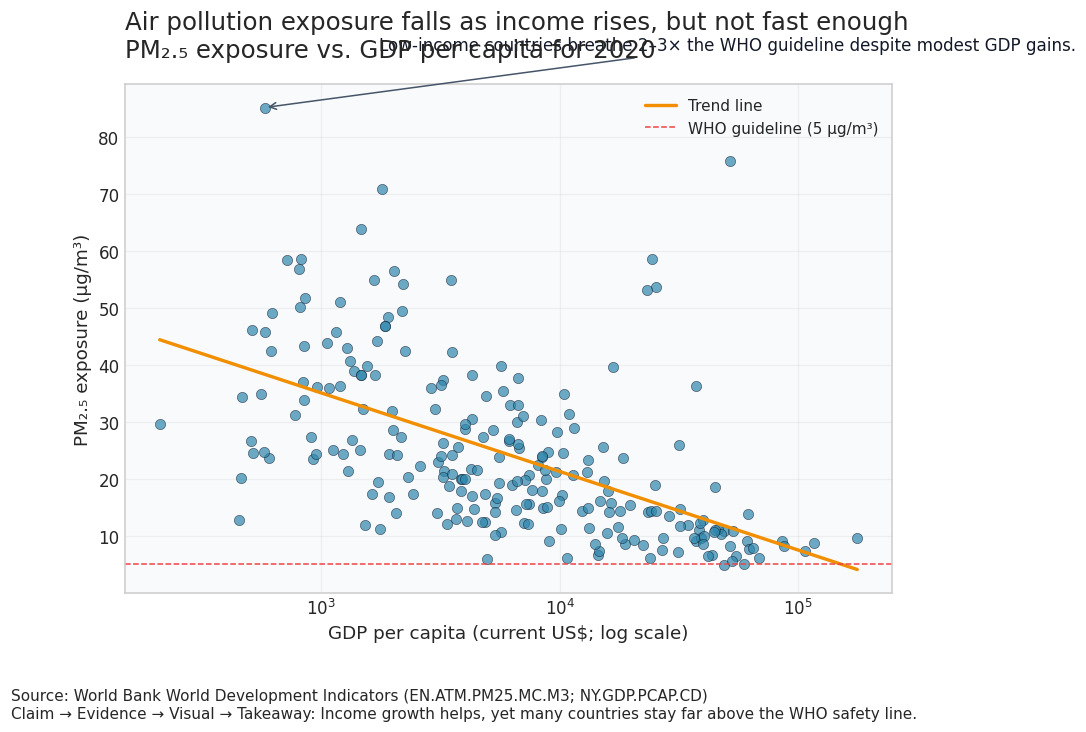

In [7]:
baseline_style()
fig, ax = plt.subplots(figsize=(9, 6))

ax.scatter(
    country_level["gdp_per_capita"],
    country_level["pm25"],
    s=45,
    alpha=0.7,
    color=COLORBLIND_FRIENDLY[0],
    edgecolor="#0f172a",
    linewidth=0.4,
)

sorted_gdp = np.linspace(country_level["gdp_per_capita"].min(), country_level["gdp_per_capita"].max(), 200)
ax.plot(sorted_gdp, trend_line(np.log10(sorted_gdp)), color=COLORBLIND_FRIENDLY[1], linewidth=2.2, label="Trend line")

ax.set_xscale("log")
ax.set_xlabel("GDP per capita (current US$; log scale)")
ax.set_ylabel("PM₂.₅ exposure (μg/m³)")

title_text = TITLE + "\n" + SUBTITLE
ax.set_title(title_text, loc="left", pad=18)
ax.axhline(5, color="#EF4444", linestyle="--", linewidth=1, label="WHO guideline (5 μg/m³)")
ax.legend(frameon=False, loc="upper right")

worst_case = country_level.sort_values("pm25", ascending=False).iloc[0]
ax.annotate(
    ANNOTATION,
    xy=(worst_case["gdp_per_capita"], worst_case["pm25"]),
    xytext=(worst_case["gdp_per_capita"] * 3, worst_case["pm25"] + 10),
    arrowprops=dict(arrowstyle="->", color="#475569"),
    fontsize=11,
    color="#111827",
)

caption_text = SOURCE + "\n" + "Claim → Evidence → Visual → Takeaway: Income growth helps, yet many countries stay far above the WHO safety line."
fig.text(0.01, -0.08, caption_text, fontsize=10)
plt.show()


### Accessibility checklist
- Dot colors and trend line use contrasting, colorblind-friendly hues.
- Log axis labeled clearly to avoid misinterpretation.
- Annotation highlights interpretation rather than restating the obvious.
- WHO guideline line provides context without dual axes.

In [8]:
save_last_fig("day03_solution_plot.png")


Figure saved to plots/day03_solution_plot.png


<Figure size 704x528 with 0 Axes>

## Step 7. Reflect on limitations and ethics
- PM₂.₅ estimates rely on satellite models and sparse ground monitors; uncertainties are highest in low-income regions.
- GDP per capita doesn't capture inequality within countries; pollution burdens can fall disproportionately on marginalized communities.
- Encourage learners to surface questions they cannot answer with this scatter alone (e.g., policy causes, health outcomes).
- Invite a discussion on ethical framing: avoid implying pollution is an acceptable trade-off for growth.